# Extract photometric flux from spectra with HAWC+ filters

## Read in SOFIA/HAWC+ filters

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

In [2]:
filter_dir = '/Users/yaolun/astro_tools/sofia_filters/hawc+/'
band = ['bandA','bandB','bandC','bandD','bandE']
central_wave = [53., 63., 89., 154., 214.]  

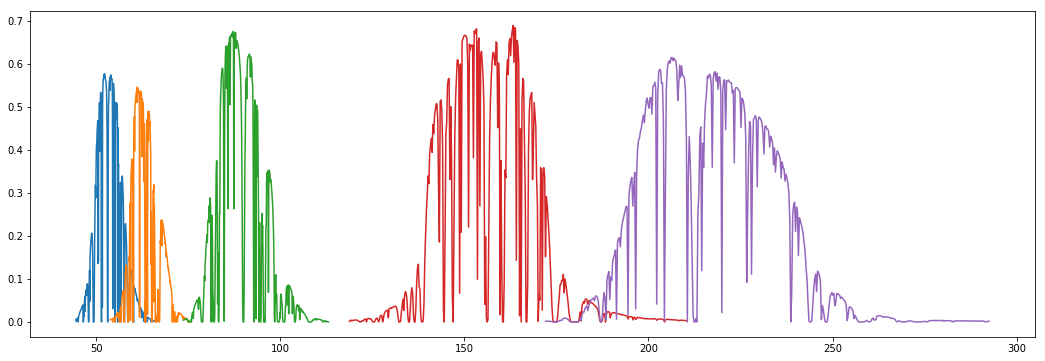

In [3]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
for b in band:
    data = ascii.read(filter_dir+b+'.txt', data_start=2)
    ax.plot(data['Wavelength'], data['Tot.Trans.'])

## BHR71

### Read in the observations

In [8]:
# micron, Jy
spitzer = ascii.read('/Users/yaolun/bhr71/best_calibrated/bhr71_spitzer_irs.txt',
                     header_start=None, data_start=3, names=['Wavelength','Flux_Density','Error'])
# pacs = ascii.read('/Users/yaolun/bhr71/best_calibrated/BHR71_pacs_weighted_continuum.txt')
# spire = ascii.read('/Users/yaolun/bhr71/best_calibrated/BHR71_spire_corrected_continuum.txt')

### Choose the desired filters

In [45]:
i = 0
fil = ascii.read(filter_dir+band[i]+'.txt', data_start=2)

### Aperture size

In [47]:
area = np.pi*(31.8/2)**2

### Perform on cube spectra

### Using the ratio of Spitzer to PACS in 1-D spectra as the reference

In [23]:
spitzer_tot = np.trapz(spitzer['Flux_Density']*1e-23*c/(spitzer['Wavelength']*1e-4)/spitzer['Wavelength'],
                       x=spitzer['Wavelength'])
pacs_tot = np.trapz(pacs['Flux_Density(Jy)']*1e-23*c/(pacs['Wavelength(um)']*1e-4)/pacs['Wavelength(um)'], 
                    x=pacs['Wavelength(um)'])
ratio = pacs_tot/spitzer_tot
print spitzer_tot, pacs_tot, ratio

9.23760144535e-10 7.79837825113e-09 8.44199470746


In [34]:
datadir = '/Users/yaolun/bhr71/best_calibrated/fitting/pacs/data/cube/'
objname = 'BHR71'
suffix = 'hsa'

# choose filter
i = 0
fil = ascii.read(filter_dir+band[i]+'.txt', data_start=2)

In [53]:
import astropy.constants as const
from scipy.interpolate import interp1d
c = const.c.cgs.value

flux_convolved = []

for j in range(1,26):
    spec = ascii.read(datadir+objname+'_pacs_pixel'+str(j)+'_'+suffix+'.txt')
    spec['Flux_Density(Jy)'][np.isnan(spec['Flux_Density(Jy)'])] = 0
#     spec_tot = np.trapz(spec['Flux_Density(Jy)']*1e-23*c/(spec['Wavelength(um)']*1e-4)/spec['Wavelength(um)'], 
#                     x=spec['Wavelength(um)'])
    wave_tot = np.hstack((spitzer['Wavelength'],
                          spec['Wavelength(um)']))
    flux_tot = np.hstack((spitzer['Flux_Density'],
                          spec['Flux_Density(Jy)']))
    # sort
    sorter = np.argsort(wave_tot)
    wave_tot = wave_tot[sorter]
    flux_tot = flux_tot[sorter]
    
    # convert the flux unit from Jy to F_lambda (erg/s/cm2/um)
    fnu2fl = 1e-23*c/(wave_tot*1e-4)/wave_tot
    flux_tot = flux_tot * fnu2fl
    area = 8.4**2
    
    flux_interp = interp1d(wave_tot, flux_tot)
    flux = np.trapz(flux_interp(fil['Wavelength'])*fil['Tot.Trans.'],x=fil['Wavelength'] )
    
    flux_convolved.append(flux/area/33.88)
    
    print 'pixel', j, central_wave[i], 'um', flux/area/33.88, 'erg/s/cm2/um/as2'

pixel 1 53.0 um 1.04806000996e-14 erg/s/cm2/um/as2
pixel 2 53.0 um 1.04347870156e-14 erg/s/cm2/um/as2
pixel 3 53.0 um 1.09658847999e-14 erg/s/cm2/um/as2
pixel 4 53.0 um 1.65401144459e-14 erg/s/cm2/um/as2
pixel 5 53.0 um 1.2736578257e-14 erg/s/cm2/um/as2
pixel 6 53.0 um 8.4898146091e-15 erg/s/cm2/um/as2
pixel 7 53.0 um 1.37471817605e-14 erg/s/cm2/um/as2
pixel 8 53.0 um 1.37635503649e-14 erg/s/cm2/um/as2
pixel 9 53.0 um 1.57408306637e-14 erg/s/cm2/um/as2
pixel 10 53.0 um 9.94869112099e-15 erg/s/cm2/um/as2
pixel 11 53.0 um 1.23729938971e-14 erg/s/cm2/um/as2
pixel 12 53.0 um 1.22376468258e-14 erg/s/cm2/um/as2
pixel 13 53.0 um 5.31022992584e-14 erg/s/cm2/um/as2
pixel 14 53.0 um 4.29042653261e-14 erg/s/cm2/um/as2
pixel 15 53.0 um 1.1323169973e-14 erg/s/cm2/um/as2
pixel 16 53.0 um 1.20123434806e-14 erg/s/cm2/um/as2
pixel 17 53.0 um 1.30796030505e-14 erg/s/cm2/um/as2
pixel 18 53.0 um 1.35797746917e-14 erg/s/cm2/um/as2
pixel 19 53.0 um 1.85484041406e-14 erg/s/cm2/um/as2
pixel 20 53.0 um 1.24288

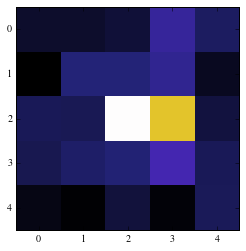

In [58]:
flux_convolved = np.array(flux_convolved).reshape(5,5)
plt.imshow(flux_convolved, interpolation='None', cmap=plt.cm.CMRmap)

## Sources list investigation

In [32]:
bands = np.array([53, 63, 89, 154, 214])

In [4]:
def GetHAWCFlux(spec):
    import numpy as np
    from scipy.interpolate import interp1d
    from astropy.modeling import models, fitting, powerlaws
#     import matplotlib.pyplot as plt
    
    bands = np.array([53., 63., 89., 154., 214.])
    
    # mask out nan value
    selector = np.isnan(spec['Flux_Density(Jy)']) == False
    spec = spec[selector]
    
    flux_estimate = np.empty_like(bands)
    for b in bands:
        if (b > spec['Wavelength(um)'].min()) & (b < spec['Wavelength(um)'].max()):
            f = interp1d(spec['Wavelength(um)'], spec['Flux_Density(Jy)'])
            flux_estimate[bands == b] = f(b)
        elif (b < spec['Wavelength(um)'].min()):
            flux_estimate[bands == b] = np.nanmean(spec['Flux_Density(Jy)'][0:400])
        elif (b > spec['Wavelength(um)'].max()):
            # fit with a power law
            pow_model = powerlaws.PowerLaw1D(spec['Flux_Density(Jy)'].max(), b, 0)
            fitter = fitting.LevMarLSQFitter()
            fit = fitter(pow_model, spec['Wavelength(um)'][-1000:], spec['Flux_Density(Jy)'][-1000:])
            flux_estimate[bands == b] = fit(b)
            
    return flux_estimate

In [6]:
# source list
sources = ['L1551-IRS5','GSS30-IRS1']
# 
datadir = '/Volumes/SD-Mac/CDF_archive_v2/'
pix_list = [13, 7, 8, 9, 12, 14, 17, 18, 19]
pix_size = 8.4**2

# Flux Density threshold in band A
flux_cut = 0.21 * pix_size # Jy -> 0.21 Jy/as2

flux = {}
flux_reduced = {}
for s in sources:
    flux_dum = np.empty((9,5))
    for pix in pix_list:
        spec = ascii.read(datadir+s+'/pacs/data/cube/'+s+'_pacs_pixel'+str(pix)+'_hsa.txt')
        flux_dum[pix_list.index(pix),:] = GetHAWCFlux(spec)
#         print(pix, flux_dum[pix_list.index(pix),:]/pix_size)
    
    flux[s] = flux_dum

    print(s, len(np.where(flux[s][:,0] >= flux_cut)[0])) # , flux[s][:,0]
    
    flux_reduced[s] = np.vstack((flux_dum[0,:],
                                 np.nanmedian(flux_dum[1:,:], axis=0),
                                 np.nanmax(flux_dum[1:,:], axis=0),
                                 np.percentile(flux_dum[1:,:], 90, axis=0),
                                 np.percentile(flux_dum[1:,:], 25, axis=0),
                                 np.nanmin(flux_dum[1:,:], axis=0)))

13 [ 4.7481119   4.89515823  4.83778178  2.36663016  0.97488232]
7 [ 0.33345679  0.38010681  0.3973223   0.30447948  0.19617603]
8 [ 0.52088644  0.38311059  0.15646465  0.23734944  0.25314517]
9 [ 0.07354588  0.05087701  0.0270209   0.09861251  0.10121399]
12 [ 0.47626255  0.5371246   1.00015346  0.94630946  0.54597544]


/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


14 [ 0.58204149  0.64506032  0.51447258  0.63454179  0.31719419]
17 [ 0.07122142  0.07553757  0.25939713  0.28053352  0.12933839]
18 [ 0.07690622  0.07748273  0.3645835   0.54693371  0.31991777]
19 [ 0.08828278  0.10441983  0.21776327  0.24982923  0.19121141]
L1551-IRS5 5
13 [ 1.91409461  1.81058599  1.33500277  0.47541661  0.19565044]


/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


7 [ 0.13887784  0.14772806  0.20345189  0.13897191  0.05481592]
8 [ 0.14700443  0.11632527  0.2084244   0.20166709  0.1255733 ]
9 [ 0.06931041  0.06267648  0.15211186  0.23171704  0.15145716]
12 [ 0.31381397  0.32451451  0.35329628  0.23325897  0.09175551]


/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


14 [ 0.54148012  0.56588164  0.66203918  0.4452725   0.16048242]
17 [ 0.11873587  0.12522903  0.22602262  0.23990347  0.09892216]
18 [ 0.27258407  0.29459872  0.3904135   0.31566447  0.12260776]
19 [ 0.30858204  0.35325855  0.42325527  0.29942844  0.14980961]
GSS30-IRS1 5


### For Band C, D, and E, investigating the sensitivity at the entire 5x5 IFU

In [13]:
# source list
sources = ['L1551-IRS5','GSS30-IRS1']
# 
datadir = '/Volumes/SD-Mac/CDF_archive_v2/'
pix_list = [13, 7, 8, 9, 12, 14, 17, 18, 19,
            1,2,3,4,5,6,20,21,22,23,24,25]
pix_size = 8.4**2

# Flux Density threshold in band A
# flux_cut = 0.21 * pix_size # Jy -> 0.21 Jy/as2
flux_cut = np.array([0.031, 0.00788, 0.00346])*pix_size # Jy/as2

flux = {}
flux_reduced = {}
for s in sources:
    for b in [0,1,2]:
        flux_dum = np.empty((25,5))
        for pix in pix_list:
            spec = ascii.read(datadir+s+'/pacs/data/cube/'+s+'_pacs_pixel'+str(pix)+'_hsa.txt')
            flux_dum[pix_list.index(pix),:] = GetHAWCFlux(spec)
        flux[s] = flux_dum

        print(s, b, len(np.where(flux[s][:,0] >= flux_cut[b]*5)[0])) # , flux[s][:,0]

        flux_reduced[s] = np.vstack((flux_dum[0,:],
                                     np.nanmedian(flux_dum[1:,:], axis=0),
                                     np.nanmax(flux_dum[1:,:], axis=0),
                                     np.percentile(flux_dum[1:,:], 90, axis=0),
                                     np.percentile(flux_dum[1:,:], 25, axis=0),
                                     np.nanmin(flux_dum[1:,:], axis=0)))

/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/s

L1551-IRS5 0 5


/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/s

L1551-IRS5 1 12


/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/s

L1551-IRS5 2 17


/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/s

GSS30-IRS1 0 6


/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/s

GSS30-IRS1 1 13


/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


GSS30-IRS1 2 19


/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)
/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/astropy/modeling/powerlaws.py:54: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


### Write out the results

In [35]:
foo = open('/Volumes/SD-Mac/Dropbox/sofia_embedded_b-field/digit_sources.txt', 'w')
foo.write('{:>10} \t {:>10} \t {:>10} \t {:>10} \t {:>10} \t {:>10} \n'\
          .format('region', 'F_53um', 'F_63um', 'F_89um', 'F_154um', 'F_214um'))
foo.write('{:>10} \t {:>10} \t {:>10} \t {:>10} \t {:>10} \t {:>10} \n'\
          .format('', '(Jy/as2)', '(Jy/as2)', '(Jy/as2)', '(Jy/as2)', '(Jy/as2)'))
regions = ['center','med-ring','max-ring', '75th-ring', '25th-ring','min-ring']
pix_size = 8.4**2
for s in sources:
    foo.write('# {} \n'.format(s))
    for r in regions:
        foo.write('{:>10} \t {:10f} \t {:10f} \t {:10f} \t {:10f} \t {:10f} \n'\
                  .format(r, flux_reduced[s][regions.index(r),0]/pix_size, flux_reduced[s][regions.index(r),1]/pix_size,
                          flux_reduced[s][regions.index(r),2]/pix_size, flux_reduced[s][regions.index(r),3]/pix_size,
                          flux_reduced[s][regions.index(r),4]/pix_size))
foo.close()

In [8]:
s = 'BHR71'
spec = ascii.read(datadir+s+'/pacs/data/cube/'+s+'_pacs_pixel13_hsa.txt')

array([30, 44, 83, 81, 46])

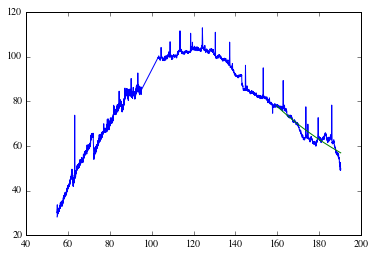

In [33]:
GetHAWCFlux(spec)

# For illustrating the envelope and outflow emission range

In [85]:
from hyperion.model import ModelOutput
import astropy.constants as const
pc = const.pc.cgs.value

rtout = '/Volumes/SD-Mac/model131.rtout'

m = ModelOutput(rtout)
im = m.get_image(group=8, inclination=0, distance=200.*pc, units='MJy/sr')

rmax = max(m.get_quantities().r_wall)
w = np.degrees(rmax / im.distance) * 3600.

/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide
/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide
/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


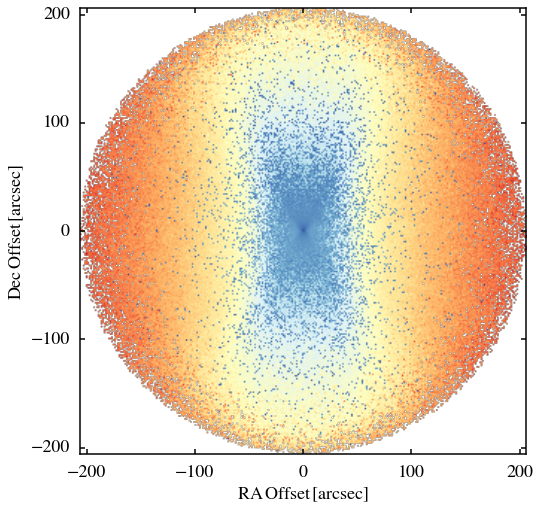

In [129]:
# sum over wave < 50 um and wave > 50 um separately
outflow = im.wav <= 50.
envelope = im.wav > 50.

im_outflow = np.nansum(im.val[:,:,outflow], axis=2)
im_envelope = np.nansum(im.val[:,:,envelope], axis=2)

fig = plt.figure(figsize=(8,8),frameon=False)
ax = fig.add_subplot(111)

# ax.imshow(np.log10(im_outflow[::-1,:]/im_outflow[::-1,:].max()), vmin=-15, cmap='CMRmap', origin='lower',
#           extent=[-w, w, -w, w], aspect=1)
# ax.imshow(np.log10(im_envelope[::-1,:]/im_envelope[::-1,:].max()), vmin=-15, cmap='CMRmap_r', origin='lower',
#           extent=[-w, w, -w, w], aspect=1, alpha=0.5)

outflow_norm = im_outflow[::-1,:]/im_outflow[::-1,:].max()
envelope_norm = im_envelope[::-1,:]/im_envelope[::-1,:].max()
imm = outflow_norm/envelope_norm

ax.imshow(np.log10(imm), cmap='RdYlBu', extent=[-w,w,-w,w])

ax.set_xlabel(r'$\rm{RA\,Offset\,[arcsec]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Dec\,Offset\,[arcsec]}$', fontsize=18)

[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
# ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

fig.savefig('/Users/yaolun/Dropbox/sofia-cycle5/outflow-envelope.pdf', format='pdf', dpi=300, bbox_inches='tight')